In [1]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import string
import collections
import time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import gc
import itertools
import nltk
# import tensorflow as tf    
# tf.compat.v1.disable_v2_behavior() # <-- HERE !

# Packages for data preparation
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from nltk.corpus import stopwords
from nltk import tokenize, sent_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import average_precision_score, precision_recall_curve, accuracy_score, roc_auc_score, confusion_matrix
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

# Word cloud visualization libraries
from PIL import Image


from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from collections import Counter




from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Embedding
from keras.layers import Flatten, Dense, Dropout, AlphaDropout, ThresholdedReLU, Convolution1D, ZeroPadding1D, Activation, MaxPooling1D, SpatialDropout1D, Input 
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional,BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.wrappers.scikit_learn import KerasClassifier

nltk.download('punkt')

pd.set_option('display.max_colwidth',None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir 
checkpoint_dir = base_dir +'/data'

Mounted at /content/drive


In [4]:

NUM_LABELS = 2
DATA_PATH = base_dir + 'IMDB Dataset.csv'

In [5]:
# export
def read_data(path):
    """
    returns a pandas DataFrame from path   
    """
    df = pd.read_csv(path)
    # df = df[(df['Ocena'] != 'Bez oceny')][['Ocena','Tekst']]
    # df = df.rename(columns={'Ocena': 'LABEL_COLUMN_NAME', 'Tekst': 'TEXT_COLUMN_NAME'})
    return df

In [6]:
df = read_data(DATA_PATH)
df.head()


,review,sentiment
0,"An excellent cast who do their best with an awful script, inept direction, and some of the worst score that I have ever heard. More TV movie of the week than serious drama. Which is sad when one considers that the source material is very serious and very real. The film makers decided that instead of building drama and character, it was better to just show the most graphic and violent bits and hope that the audience would be shocked into sympathy and caring. In my opinion, one the most blatant forms of cut and paste film adapting.",negative
1,"A dreary and pointless bit of fluff (bloody fluff, but fluff). Badly scripted, with inane and wooden dialogue. You do not care if the characters (indeed, even if the actors themselves) live or die. Little grace or charm, little action, little point to the whole thing. Perhaps some of the set and setting will interest--those gaps between the boards of all the buildings may be true to the way life was lived. The framework encounter is unnecessary and distracting, and the Hoppalong Cassidy character himself is both boring and inept.",negative
2,If the writer/director is reading this (and I imagine you are since you should now be out of work) then I must tell you - I have seen some bad movies in my time but this one gets the distinction of having the worst premise I've ever heard.<br /><br />SPOILERS - Nothing happens! <br /><br />A total waste of time. I laughed out loud at the end. <br /><br />SIDE NOTE - (if the whole movie was her in a coma then does the scene where she sleeps with that guy mean someone raped her while she was knocked out?)<br /><br />Utter rubbish.,negative
3,"This is a classic B type movie that you'd rather not waste your time and see. It started well and i thought it will grow up as a good thriller, but i was mistaking. All movie long you get the feeling that soon something interesting will take place and it will suddenly turn into a tensed thriller, but that doesn't happen. It runs slowly and peacefully til the end, with nothing interesting in it. Just the ending was unexpected and original, but that's it. Vote: 2.5 out of 10. Oh, one more thing. Why is this movie rated R anyway???",negative
4,"A short review but...<br /><br />Avoid at all costs, a thorough waste of 90mins. At the end of the film I was none the wiser as to what had actually happened. It's full of cameos (Stephen Fry (3mins), Jack Dee (30 secs), the ""Philadelphia"" girls) and some vaguely recognisable people but it just doesn't make any sense. Whether the story just got lost in the edit I don't now but jeez...<br /><br />Put on a DVD instead or go to bed and get some rest!!!<br /><br />2 out of 10 (for the cameos and a Morris Minor car chase)<br /><br />",negative


In [7]:
df.sentiment.value_counts()

positive    25000
negative     2502
Name: sentiment, dtype: int64

In [8]:
# location of data
# DATA_FILE = './data/Tweets.csv'

# data columns for learning
# TEXT_COLUMN_NAME = 'text'
# LABEL_COLUMN_NAME = 'airline_sentiment'

# EMBEDDINGS FILE 
GLOVE_EMBEDDINGS_FILE = 'data/embeddings/glove.6B.100d.txt'
FASTTEXT_EMBEDDINGS_FILE = 'data/embeddings/cc.pl.300.vec'

# from gensim.models import KeyedVectors

# if __name__ == '__main__':
#     word2vec = KeyedVectors.load_word2vec_format("glove_100_3_polish.txt")

# parameters for learning
# Parameter indicating the number of words we'll put in the dictionary
# (change it per source)
NB_WORDS = 10000
VAL_SIZE = 1000  # Size of the validation set
NB_EPOCHS = 15  # Number of epochs
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
# Maximum number of words in a sequence (see the sentence distribution)
MAX_LEN = 250
EMBEDDING_DIM = 100  # Number of dimensions of the GloVe word embeddings
FASTTEXT_EMBEDDING_DIM = 300  # Number of dimensions of the FastText word embeddings
MAX_SENT_LEN = 300  # character based length
MAX_DOC_LEN = 5  # Number of sentences in text

# labels
LABELS = ['positive','negative']
label_map = {'negative':1, 'positive':0}


In [9]:
text = df['review']
sentiments = df['sentiment']

df['sentiment'] = df['sentiment'].apply(lambda x : label_map[x])
# Output first ten rows
df.head(10)

,review,sentiment
0,"An excellent cast who do their best with an awful script, inept direction, and some of the worst score that I have ever heard. More TV movie of the week than serious drama. Which is sad when one considers that the source material is very serious and very real. The film makers decided that instead of building drama and character, it was better to just show the most graphic and violent bits and hope that the audience would be shocked into sympathy and caring. In my opinion, one the most blatant forms of cut and paste film adapting.",1
1,"A dreary and pointless bit of fluff (bloody fluff, but fluff). Badly scripted, with inane and wooden dialogue. You do not care if the characters (indeed, even if the actors themselves) live or die. Little grace or charm, little action, little point to the whole thing. Perhaps some of the set and setting will interest--those gaps between the boards of all the buildings may be true to the way life was lived. The framework encounter is unnecessary and distracting, and the Hoppalong Cassidy character himself is both boring and inept.",1
2,If the writer/director is reading this (and I imagine you are since you should now be out of work) then I must tell you - I have seen some bad movies in my time but this one gets the distinction of having the worst premise I've ever heard.<br /><br />SPOILERS - Nothing happens! <br /><br />A total waste of time. I laughed out loud at the end. <br /><br />SIDE NOTE - (if the whole movie was her in a coma then does the scene where she sleeps with that guy mean someone raped her while she was knocked out?)<br /><br />Utter rubbish.,1
3,"This is a classic B type movie that you'd rather not waste your time and see. It started well and i thought it will grow up as a good thriller, but i was mistaking. All movie long you get the feeling that soon something interesting will take place and it will suddenly turn into a tensed thriller, but that doesn't happen. It runs slowly and peacefully til the end, with nothing interesting in it. Just the ending was unexpected and original, but that's it. Vote: 2.5 out of 10. Oh, one more thing. Why is this movie rated R anyway???",1
4,"A short review but...<br /><br />Avoid at all costs, a thorough waste of 90mins. At the end of the film I was none the wiser as to what had actually happened. It's full of cameos (Stephen Fry (3mins), Jack Dee (30 secs), the ""Philadelphia"" girls) and some vaguely recognisable people but it just doesn't make any sense. Whether the story just got lost in the edit I don't now but jeez...<br /><br />Put on a DVD instead or go to bed and get some rest!!!<br /><br />2 out of 10 (for the cameos and a Morris Minor car chase)<br /><br />",1
5,"This film is quite boring. There are snippets of naked flesh tossed around in a lame attempt to keep the viewer awake but they don't succeed.<br /><br />The best thing about the movie is Lena Olin--she does a masterful job handling her character, but Day-Lewis garbles most of his lines.<br /><br />Kaufman clearly had no idea how to film this. The incongruities in bouncing between domestic household/marriage issues and political crises are badly matched. Character attitudes change without explanation throughout. Badly disjointed.",1
6,"Everything about this movie is bad. everything. Ridiculous 80's haircuts. Ridiculous moustaches. Ridiculous action and fight scenes where you can actually see that the adversaries do not even hit each other. Bad, bad, bad 80's music. Repeated scenes of people running through woods. A bad guy with a silver plastic hand and silly hair. Stupid dialogue. The acting is nonexistant. Everything looks extremely cheap. This movie even surpasses ""Plan 9 from outer space"" in its utter badness.<br /><br />It's not ""funny bad"" it's just bad.",1
7,"""Whipped"" is 82 minutes long. This review is 82 words long. Three unlikable New York Lotharios, ruthless ""scammers,"" end up wooing the same woman, played by Amanda Peet, with disastr

In [10]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [11]:
X_train_, X_test_, y_train, y_test = train_test_split(
    df['review'], df['sentiment'], stratify= df['sentiment'] ,test_size=0.15, shuffle = True,random_state=37)
print('# Train data samples:', X_train_.shape[0])
print('# Test data samples:', X_test_.shape[0])
assert X_train_.shape[0] == y_train.shape[0]
assert X_test_.shape[0] == y_test.shape[0]

# Train data samples: 23376
# Test data samples: 4126


In [12]:
# tokenization with max words defined and filters
tk = Tokenizer(num_words=NB_WORDS)
tk.fit_on_texts(X_train_)
word_index = tk.word_index
print("Unique words : {}".format(len(word_index)))
print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))

Unique words : 84981
Fitted tokenizer on 23376 documents
10000 words in dictionary


In [13]:
word_index = tk.word_index
print("Unique words : {}".format(len(word_index)))

Unique words : 84981


In [14]:
# convert train and test to sequence using the tokenizer
X_train_seq_tok = tk.texts_to_sequences(X_train_)
X_test_seq_tok = tk.texts_to_sequences(X_test_)

# pad the sequences 
X_train_all_cnn = pad_sequences(X_train_seq_tok,  padding='post',maxlen=MAX_LEN)
X_test_cnn = pad_sequences(X_test_seq_tok,  padding='post',maxlen=MAX_LEN)





In [15]:
X_train_cnn, X_valid_cnn, y_train, y_valid = train_test_split(
    X_train_all_cnn, y_train, test_size=0.15, random_state=37)

assert X_valid_cnn.shape[0] == y_valid.shape[0]
assert X_train_cnn.shape[0] == y_train.shape[0]

print('Shape of training set:', X_train_cnn.shape)
print('Shape of validation set:', X_valid_cnn.shape)

Shape of training set: (19869, 250)
Shape of validation set: (3507, 250)


In [16]:
X_train_cnn

array([[   5,   28, 1410, ...,    0,    0,    0],
       [  11,   15,    3, ...,    0,    0,    0],
       [  11,    6,    3, ...,    0,    0,    0],
       ...,
       [ 282,    3,  554, ...,    0,    0,    0],
       [ 557,   54,    6, ...,    0,    0,    0],
       [  11,    6,   32, ...,    0,    0,    0]], dtype=int32)

In [17]:
print(y_train.value_counts(normalize= True))
print(y_valid.value_counts(normalize= True))
print(y_test.value_counts(normalize= True))

0    0.908954
1    0.091046
Name: sentiment, dtype: float64
0    0.909324
1    0.090676
Name: sentiment, dtype: float64
0    0.909113
1    0.090887
Name: sentiment, dtype: float64


In [18]:



def train_model(model, X_train, y_train, X_valid, y_valid):
    """
    This function trains the deep model using the training set and valdiation set.

    :param model: the Keras Classifier Model
    :param X_train: train sequences
    :param y_train: trian labels
    :return: a list of actual labels

    """
    start = time.time()
    checkpoints = []
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    checkpoint_file = checkpoint_dir + '/Checkpoints/Train-' + model.name + '-best_weights.h5'
    checkpoints.append(
        ModelCheckpoint(
            checkpoint_file,
            monitor='val_loss',
            verbose=0,
            save_best_only=True,
            save_weights_only=True,
            mode='auto',
            period=1))
    checkpoints.append(EarlyStopping(monitor='val_loss', patience=5))

    history = model.fit(
        X_train,
        y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(
            X_valid,
            y_valid),
        verbose=1,
        callbacks=checkpoints)
    # load the weights from the checkpoint file, the best weights
    model.load_weights(checkpoint_file)
    end = time.time()
    total_time = end - start
    print("Model Training and Validation time %s secs" % (total_time))
    return model,history


def eval_metric(history, metric_name):

    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, min(len(metric),NB_EPOCHS) + 1)

    plt.plot(e, metric, color='navy', label='Train ' + metric_name)
    plt.plot(e, val_metric, color='red', label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# From:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def test_model(model, X_test, y_test):
    start = time.time()
    # checkpoint
    checkpoint_file = checkpoint_dir + '/Checkpoints/Train-' + model.name + '-best_weights.h5'
    model.load_weights(checkpoint_file)
    results = model.evaluate(X_test, y_test)
    end = time.time()
    # y_class_index, y_pred_index, confidence, y_softmax = get_predictions_and_confidences(
    #     model, X_test, y_test)
    y_pred_proba = model.predict(X_test)
    y_pred = np.where(y_pred_proba > 0.5, 1,0)
    cnf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    plot_confusion_matrix(
        cnf_matrix,
        classes=LABELS,
        title="Confusion matrix")
    plt.show()
    total_time = end - start
    print("Model Training and Testing time : %s secs" % (total_time))
    print("Model Testing Accuracy : %s " % (results[1]))
    average_precision = average_precision_score(
        y_test, y_pred_proba )
    average_roc = roc_auc_score(
        y_test, y_pred_proba )
    print('Average precision score: {0:0.2f}'.format(
        average_precision))
    print('ROC AUC  score: {0:0.2f}'.format(
        average_roc))
    return results


def test_model_runs(
        model,
        X_train,
        y_train,
        X_test,
        y_test,
        epoch_stop=20,
        num_runs=3,
        verbose=0):

    sum_result = 0
    sq_sum_result = 0
    for val in range(0, num_runs):
        base_results = test_model(
            model,
            X_train,
            y_train,
            X_test,
            y_test,
            epoch_stop,
            verbose)
        sum_result = sum_result + base_results[1]
        sq_sum_result = sq_sum_result + base_results[1] * base_results[1]
    mean_accuracy = sum_result / num_runs
    variance = sq_sum_result / num_runs - mean_accuracy * mean_accuracy
    stddev = variance**(.5)
    return mean_accuracy, stddev


def compare_loss(history, base_history, model_name, base_history_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = history.history['val_loss']

    e = range(1, NB_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label=base_history_name)
    plt.plot(e, loss_model, 'red', label=model_name)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.show()


def read_embedding(path):

    embeddings_index = {}
    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    return embeddings_index


def create_embedding_matrix(tokenizer, embedding_dim, embeddings_index):

    word_index = tokenizer.word_index
    if tokenizer.num_words:  # if num words is set, get rid of words with too high index
        word_index = {key: word_index[key] for key in word_index.keys()
                      if word_index[key] < (tokenizer.num_words + 1)}
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


In [19]:
embeddings = read_embedding(base_dir + GLOVE_EMBEDDINGS_FILE)

Model: "KimCNN-Visualization"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 250, 100)     1000100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 128)     38528       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 250, 128)     51328       embedding[0][0]                  
_______________________________________________________________________________

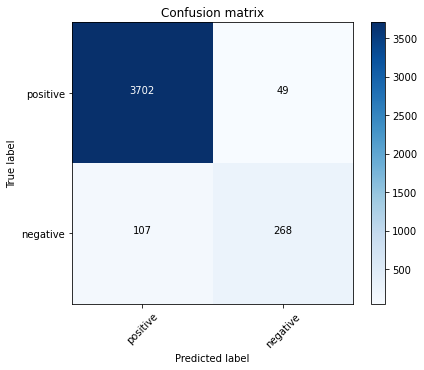

Model Training and Testing time : 1.155116319656372 secs
Model Testing Accuracy : 0.9621909856796265 
Average precision score: 0.88
ROC AUC  score: 0.98
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 250, 100)     1000100     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 128)     38528       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2

In [20]:
# create embedding matrix for the experiment
emb_matrix = create_embedding_matrix(tk, 100, embeddings)


def single_channel_kim_cnn():
    text_seq_input = Input(shape=(MAX_LEN,), dtype='int32')
    text_embedding = Embedding(NB_WORDS + 1,
                               EMBEDDING_DIM,
                               weights=[emb_matrix],
                               trainable=True,
                               input_length=MAX_LEN)(text_seq_input)

    filter_sizes = [3, 4, 5]
    convs = []
    for filter_size in filter_sizes:
        l_conv = Convolution1D(
            filters=128,
            kernel_size=filter_size,
            padding='same',
            activation='relu')(text_embedding)
        l_pool = MaxPooling1D(filter_size)(l_conv)
        convs.append(l_pool)

    merge = concatenate(convs, axis=1)
    convol = Convolution1D(128, 5, activation='relu')(merge)
    pool1 = GlobalMaxPooling1D()(convol)
    dense = Dense(128, activation='relu', name='last_but_one')(pool1)
    out = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=[text_seq_input], outputs=out,
                  name="KimCNN-Visualization")
    model.summary()

    return model


single_channel_kim_model = single_channel_kim_cnn()
# train kim's cnn
single_channel_kim_model_history = train_model(
    single_channel_kim_model, X_train_cnn, y_train, X_valid_cnn, y_valid)
# test the models to see results are same
test_model(single_channel_kim_model, X_test_cnn, y_test)
# make a copy
# single_channel_kim_model_copy = models.clone_model(
#     single_channel_kim_model)  # create a copy of Kim's CNN
# single_channel_kim_model.set_weights(
#     single_channel_kim_model_copy.get_weights())  # transfer the weights
# # test the models to see results are same
# test_model(single_channel_kim_model, X_test, y_test)
# # Get rid of the classification layer
# for layer in single_channel_kim_model_copy.layers:
#   layer._name = layer.name + str("_2")
# single_channel_kim_model_copy.layers.pop()
# single_channel_kim_model_copy.outputs = [
#     single_channel_kim_model_copy.layers[-1].output]
# single_channel_kim_model_copy.layers[-1]._outbound_nodes = []
# single_channel_kim_model_copy.summary()



model2 = Model(single_channel_kim_model.input, single_channel_kim_model.layers[-2].output)
model2.summary()









In [21]:
# # get the hidden features from a layer back
hidden_features = model2.predict(X_test_cnn)

In [22]:
hidden_features.shape

(4126, 128)

In [23]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# perform PCA on the hidden features
pca = PCA(n_components=30)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

# Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(pca_result)


Variance PCA: 0.985133945941925
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4126 samples in 0.038s...
[t-SNE] Computed neighbors for 4126 samples in 0.526s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4126
[t-SNE] Computed conditional probabilities for sample 2000 / 4126
[t-SNE] Computed conditional probabilities for sample 3000 / 4126
[t-SNE] Computed conditional probabilities for sample 4000 / 4126
[t-SNE] Computed conditional probabilities for sample 4126 / 4126
[t-SNE] Mean sigma: 0.614640
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.082092
[t-SNE] KL divergence after 1000 iterations: 1.504425


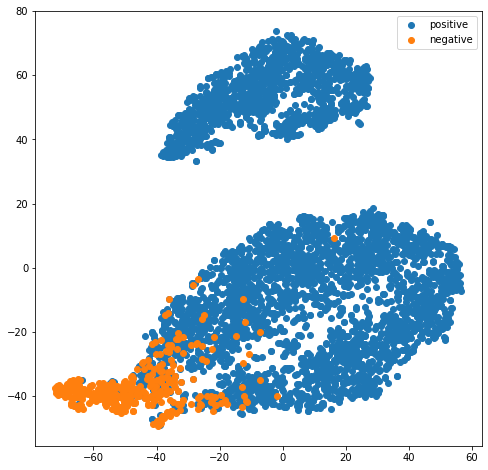

In [24]:
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

color_map = y_test
plt.figure(figsize=(8,8))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=LABELS[cl])
plt.legend()
plt.show()

Text(0, 0.5, 'Proportion of Explained Variance')

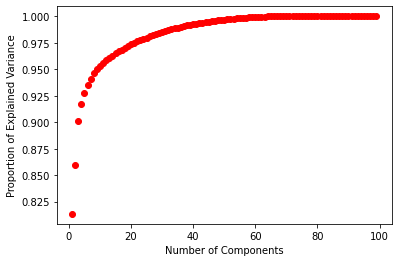

In [25]:
explained_var = []
for components in range(1,100,1):
  pca = PCA(n_components=components)
  pca.fit(hidden_features)
  explained_var.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1,100,1),explained_var,"ro")
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Explained Variance")

Explained variance of the PCA step: 95%


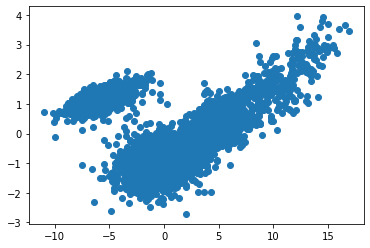

In [26]:
from sklearn.decomposition import PCA
import seaborn as sns

components = 10

palette = np.array(sns.color_palette("hls", 120))

pca = PCA(n_components=components)
pca.fit(hidden_features)
pca_dtm = pca.transform(hidden_features)

plt.scatter(pca_dtm[:,0],pca_dtm[:,1])

explained_variance = pca.explained_variance_ratio_.sum()
print("Explained variance of the PCA step: {}%".format(
    int(explained_variance * 100)))

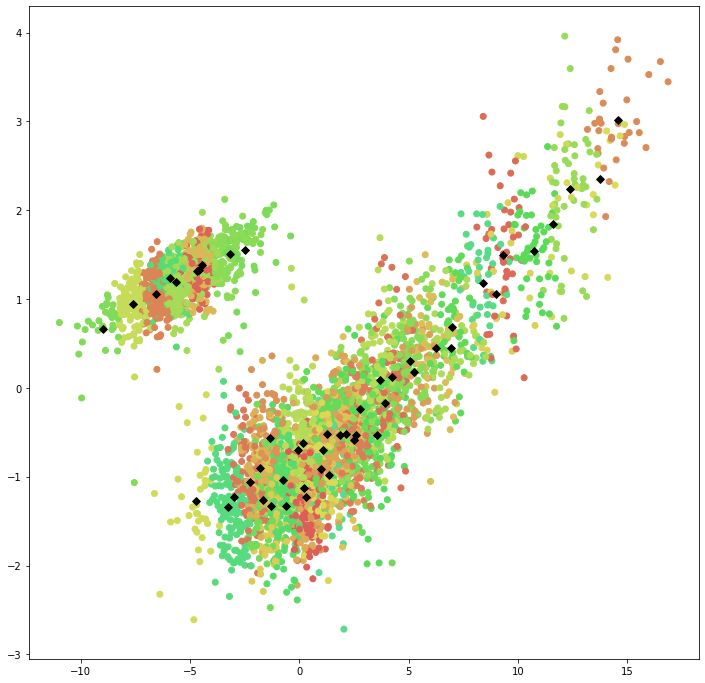

In [33]:
from sklearn.cluster import KMeans
palette = np.array(sns.color_palette("hls", 125))

model = KMeans(n_clusters=50,init='k-means++',max_iter=100,random_state=11)
clustered = model.fit(pca_dtm)
centroids = model.cluster_centers_
y = model.predict(pca_dtm)
plt.figure(figsize=(12,12))
ax = plt.subplot()

ax.scatter(pca_dtm[:,0],pca_dtm[:,1],c=palette[y.astype(np.int)])
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

ax.scatter(centroids_x, centroids_y, marker='D', c='black', s=30)
plt.show()

In [ ]:
X_test_

16806                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [34]:
KM_clustered = pd.concat([X_test_,y_test], axis=1)
KM_clustered.loc[:,'Cluster'] = model.labels_ # labeliki do danych

In [35]:
KM_clustered

,review,sentiment,Cluster
16806,"this is one of my all time favourite films. its one of those films where i know every line but can still watch it repeatedly without losing interest. i always throw on this film if I'm going on holiday, or if i don't want to go to the gym, just seeing Nikki's gorgeous body will give me the motivation i need. Its an easy to watch film which always keeps me smiling but i know it wont be everyones cup of tea, but if like me you love films that are shot beautifully and have comedy, romance and an interesting plot you will love it. It is filled with great characters and Ben and Nikki are both gorgeous so anyone can stare at something appealing. BOTTOM LINE......YOU HAVE TO GIVE IT A TRY! I watched it on TV one day by fluke and loved it that i had to go out and track it down which took some time and i could watch it everyday. MY FATHER THE HERO I LOVE YOU!!!",0,24
26938,"this took me back to my childhood in the 1950 's so corny but just fab no one ever could play FLASH GORDON like LARRY BUSTER CRABBE, just great. i have two more series to view flash gordon's trip to mars and flash gordon conquers the universe cannot wait<br /><br />",0,39
25249,"This little-appreciated movie is one of my favorites. I can watch it over and over. Dreyfus and Braga are masterful, but Raul Julia steals the show! A tongue-in-cheek, menacingly humorous Gomez Addams, with just the right tone for this irreverent spoof of this oft-told story.<br /><br />Generally untrumpeted and unappreciated, Moon Over Parador allows you to check out of reality and join the fun going on up on the screen. Two thumbs up!",0,16
7216,"Antwone Fisher's story of childhood neglect and abuse is an inspiration to all among us who witnessed or even experienced the plight of foster children. Abandoned by a troubled mother, Antwone has never met his father. Growing up with ""church going"" abusers who use the ""n-word"" not only to intimidate and hurt but also as a term of endearment, as a young man witnessing how his best friend is killed in a hold-up, enduring racial slurs and being teased while serving in the Navy, Antwone's anger is slowly turned into positive power when counseled by a Navy psychiatrist, and a love enters his life.<br /><br />The scene where Antwone meets his birth mother is one of the most powerful moments in the film. Stunned by the unexpected confrontation, the woman listens in silence to hear the young man tell her how he has lived a life without crime, addictions to drugs, fathering children left and right, all despite his utterly adverse circumstances.<br /><br />If that scene wasn't powerful enough, the very next one drives it home (and opens the flood gates): A reception to welcome home Antwone; dozens of smiling faces and open arms announcing that HE is part of this great family.<br /><br />One of the messages delivered by this wonderful film is that there are many well-meaning and sincere people working to help orphans and unwanted children. Even if some of the homes and administrators don't seem to care and appear self-serving, many do give it their all. The character who found Antwone's ""file"" once he disclosed the circumstances of his birth is one of those ""bright lights"" in the darkness of the system.<br /><br />The DVD includes a French Language track, various subtitle choices, as well as additional features and information about foster parenting.<br /><br />As a Clevelander I appreciated the location footage. No matter where you are from, you will be deeply moved by this autobiographical gem.",0,23
24368,"I really liked this one. (SPOILERS??) It had a really good plot, the main female in this movie is really kewl.<br /><br />Despite the fact that she's the only one left alive and her lover dead, it seemed to be much like Ninja Scroll. Another kick ass movie. ;)<br /><br />Watch it in japanese with subtitles. I don't know where the idiots who learned to speak english are, but for some reason all dubs get an F in t

In [36]:
KM_clust_sizes = KM_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
# KM9_clust_sizes['Cluster'].rename(dict_clust.values())
KM_clust_sizes

,KM_size
Cluster,
0,128
1,101
2,44
3,61
4,102
5,114
6,178
7,30
8,69


In [37]:
print(KM_clustered.sentiment.value_counts(normalize = True))
print(pd.crosstab(KM_clustered.sentiment,KM_clustered.Cluster,normalize='columns').T.reset_index(drop = True))
cross = pd.crosstab(KM_clustered.sentiment,KM_clustered.Cluster,normalize='columns').T.reset_index(drop = True)

0    0.909113
1    0.090887
Name: sentiment, dtype: float64
sentiment         0         1
0          1.000000  0.000000
1          1.000000  0.000000
2          0.090909  0.909091
3          0.819672  0.180328
4          1.000000  0.000000
5          0.982456  0.017544
6          1.000000  0.000000
7          0.000000  1.000000
8          1.000000  0.000000
9          1.000000  0.000000
10         0.918367  0.081633
11         0.989899  0.010101
12         1.000000  0.000000
13         1.000000  0.000000
14         1.000000  0.000000
15         0.584906  0.415094
16         1.000000  0.000000
17         1.000000  0.000000
18         0.200000  0.800000
19         1.000000  0.000000
20         0.083333  0.916667
21         1.000000  0.000000
22         0.058824  0.941176
23         1.000000  0.000000
24         1.000000  0.000000
25         0.972477  0.027523
26         1.000000  0.000000
27         0.296296  0.703704
28         1.000000  0.000000
29         1.000000  0.000000
30        

          word  count
20          as      3
21         one      3
22         and      3
23    terrible      3
24          do      3
25        been      3
26       story      3
27        what      3
28          on      3
29         ...      3
30      sequel      2
31        just      2
32       first      2
33        that      2
34  impossible      2
35           A      2
36         not      2
37         end      2
38         was      2
39          by      2
40         out      2
41        from      2
42         Too      2
43         all      2
44    watching      2
45      boring      2
46          so      2
47         but      2
48    actually      2
49      ending      2


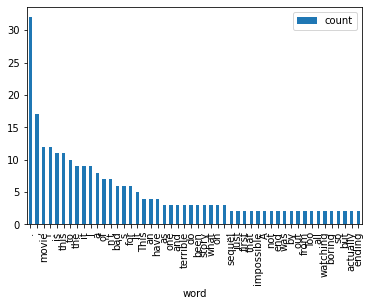

In [39]:
KM_clustered_words = KM_clustered[KM_clustered.Cluster==20]
corpus = KM_clustered_words['review'].tolist()
words = [tokenize.word_tokenize(x) for x in corpus]
words = [y for x in words for y in x]
word_freq = pd.DataFrame(nltk.FreqDist(words).most_common(50), columns=['word','count'])
print(word_freq[20:])

word_freq.plot.bar(x='word')